## Spatial Surface story

Absorb this into a main plot notebook. 

In [1]:
from xarrayutils.utils import xr_linregress
import matplotlib
from xhistogram.xarray import histogram
from sklearn import linear_model

In [2]:
%load_ext autoreload
%autoreload 2
import pathlib
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import warnings
from cmip6_omz.upstream_stash import zarr_exists

from dask.diagnostics import ProgressBar

from cmip6_omz.omz_tools import mask_basin

from cmip6_omz.units import convert_mol_m3_mymol_kg
from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.postprocessing import concat_members

from xarrayutils.filtering import filter_2D
from xarrayutils.utils import linear_trend
from xarrayutils.plotting import map_util_plot
import cartopy.crs as ccrs

import pathlib
from dask.diagnostics import ProgressBar

%matplotlib inline
import numpy as np
from xarrayutils.utils import sign_agreement
from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend, mask_multi_model

plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'
xr.set_options(cmap_sequential='cividis', display_style='html', keep_attrs=True)

In [3]:
def make_mask(ds, threshold):
    # cut all data to a particular threshold
        # convert o2 value units
    o2 = convert_mol_m3_mymol_kg(ds.o2_min_value)
    mask = (o2.mean('time')<threshold) # shoulf focus only on the real core
#     mask = (o2.max('time')<threshold) # shoulf focus only on the real core
    return mask

def preprocess(ds, threshold):
    mask = make_mask(ds, threshold)
    ds = ds.where(mask)
    return ds

target_grid = xe.util.grid_global(0.5, 0.5)
def regrid(ds):
    regridder = xe.Regridder(ds, target_grid, 'bilinear', periodic=True, ignore_degenerate=True)
    return regridder(ds)

In [4]:
folder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/')
# For intermediate output
ifolder = pathlib.Path('../data/interim/oxycline_revision')
trend_slice = slice('2000','2100')

# filename = ifolder.joinpath('combined.zarr')

## preprocess and save the regridded slope output

In [5]:
## postprocess non smoothed (for the scatter plots)
flist = list(folder.glob("*omz_boundary.zarr"))
datasets_pp = {}
overwrite = False

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for ni, f in enumerate(flist):

        ds_raw = xr.open_zarr(f, consolidated=True, use_cftime=True)

        filename = ifolder.joinpath(f"single/{cmip6_dataset_id(ds_raw)}")
        print(filename)
        if not "HR" in ds_raw.source_id:
            if (not zarr_exists(filename)) or overwrite:

                # eliminate long runs
                ds = ds_raw.sel(time=slice("1850", "2101"))
                model = ds.source_id

                #                 # regrid onto a regular grid
                #                 ds = regrid(ds)

                ds = ds.assign_coords(model=model)

                # smooth the data
                #                 ds_smooth = filter_2D(ds, 2, ["x", "y"])
                # Lets not smooth for now
                ds_smooth = ds

                # add thickness
                ds_smooth["thickness"] = (
                    ds_smooth.lower_boundary - ds_smooth.upper_boundary
                )

                mask_datasets = [
                    make_mask(ds_smooth, t).assign_coords(o2_threshold=t)
                    for t in ds_smooth.o2_threshold.data
                ]
                mask = xr.concat(mask_datasets, "o2_threshold")
                ds_smooth = ds_smooth.where(mask)

                # compute trends
                trend_thickness = (
                    linear_trend(ds_smooth["thickness"], "time").slope * 100
                )
                trend_oxycline = (
                    linear_trend(ds_smooth["upper_boundary"], "time").slope * 100
                )
                trend_lower_oxycline = (
                    linear_trend(ds_smooth["lower_boundary"], "time").slope * 100
                )

                trend_thickness = trend_thickness
                trend_oxycline = trend_oxycline

                ds_out = xr.Dataset(
                    {
                        "trend_thickness": trend_thickness,
                        "trend_oxycline": trend_oxycline,
                        "trend_lower_oxycline": trend_lower_oxycline,
                    }
                )
                with ProgressBar():
                    ds_out = ds_out.load()
                ds_out = regrid(ds_out)
                ds_out = ds_out.chunk({"x": -1})
                ds_out.to_zarr(filename, consolidated=True, mode="w")
                ds_out.attrs = ds.attrs

            datasets_pp[cmip6_dataset_id(ds_raw)] = xr.open_zarr(
                filename, consolidated=True, use_cftime=True
            )
            # quick fix
            datasets_pp[cmip6_dataset_id(ds_raw)].attrs = ds_raw.attrs

# concatenate members
datasets_pp = concat_members(datasets_pp)
datasets_pp = {k:ds.mean('member_id') if 'member_id' in ds.dims else ds for k, ds in datasets_pp.items()}


#
ds_combined = xr.concat(
    datasets_pp.values(), "model", compat="override", coords="minimal", join="inner"
)
ds_combined

../data/interim/oxycline_revision/single/none.MOHC.UKESM1-0-LL.none.r1i1p1f2.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.CCCma.CanESM5-CanOE.none.r1i1p2f1.Omon.gn.v20190429.o2
../data/interim/oxycline_revision/single/none.NOAA-GFDL.GFDL-CM4.none.r1i1p1f1.Omon.gr.none.o2
../data/interim/oxycline_revision/single/none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.IPSL.IPSL-CM6A-LR.none.r14i1p1f1.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.MPI-M.MPI-ESM1-2-LR.none.r10i1p1f1.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.CSIRO.ACCESS-ESM1-5.none.r4i1p1f1.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.CCCma.CanESM5.none.r10i1p1f1.Omon.gn.v20190429.o2
../data/interim/oxycline_revision/single/none.NCC.NorESM2-LM.none.r1i1p1f1.Omon.gr.none.o2
../data/interim/oxycline_revision/single/none.MIROC.MIROC-ES2L.none.r10i1p1f2.Omon.gn.none.o2
../data/interim/oxycline_revision/single/none.M

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


<xarray.Dataset>
Dimensions:               (o2_threshold: 12, y: 360, x: 720, model: 13)
Coordinates:
  * o2_threshold          (o2_threshold) int64 0 10 20 30 40 ... 80 90 100 110
    lat                   (y, x) float64 dask.array<chunksize=(360, 720), meta=np.ndarray>
    lon                   (y, x) float64 dask.array<chunksize=(360, 720), meta=np.ndarray>
  * model                 (model) <U13 'UKESM1-0-LL' ... 'CNRM-ESM2-1'
Dimensions without coordinates: y, x
Data variables:
    trend_lower_oxycline  (model, o2_threshold, y, x) float64 dask.array<chunksize=(1, 12, 360, 720), meta=np.ndarray>
    trend_oxycline        (model, o2_threshold, y, x) float64 dask.array<chunksize=(1, 12, 360, 720), meta=np.ndarray>
    trend_thickness       (model, o2_threshold, y, x) float64 dask.array<chunksize=(1, 12, 360, 720), meta=np.ndarray>
Attributes: (12/36)
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         standard
    cmor_version:          3.4.0
    cv_version:            6.2.20.1
    data_specs_version:    01.00.29
    external_variables:    areacello volcello
    ...                    ...
    sub_experiment_id:     none
    table_id:              Omon
    table_info:            Creation Date:(13 December 2018) MD5:2b12b5db6db11...
    title:                 UKESM1-0-LL output prepared for CMIP6
    variable_id:           o2
    variant_label:         r1i1p1f2

In [6]:
ds_combined_pacific = mask_basin(ds_combined)
# ds_combined_pacific = filter_2D(ds_combined_pacific, 5, ['y', 'x'])
ds_combined_pacific = ds_combined_pacific.where(abs(ds_combined_pacific.lat)<=35)
# ds_combined_pacific = ds_combined_pacific.where(ds_combined_pacific.lon<=0)
# ds_combined_pacific = ds_combined_pacific.where(ds_combined_pacific.lon>=-150)

## Multimodel maps for changes in thickness and upper OMZ boundary
- I bet these would look better if I smooth them before taking the trend?

In [46]:
len(ds.model)

13

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


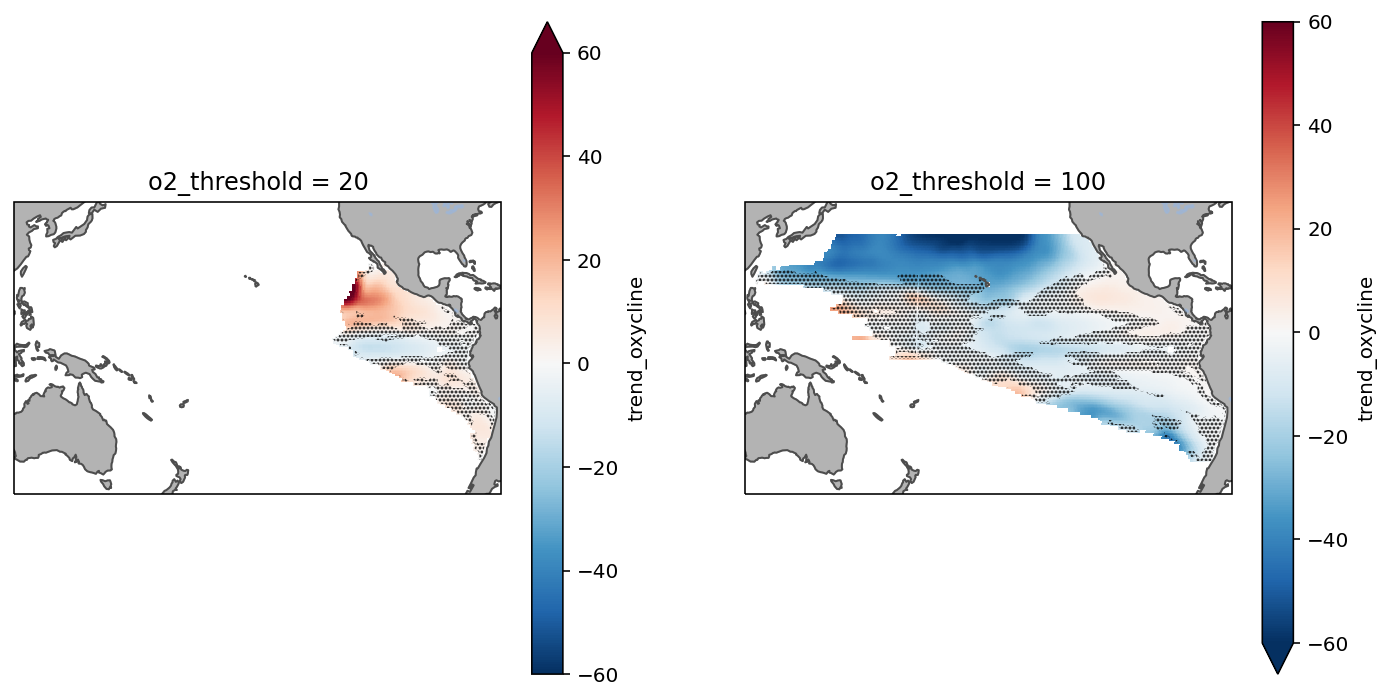

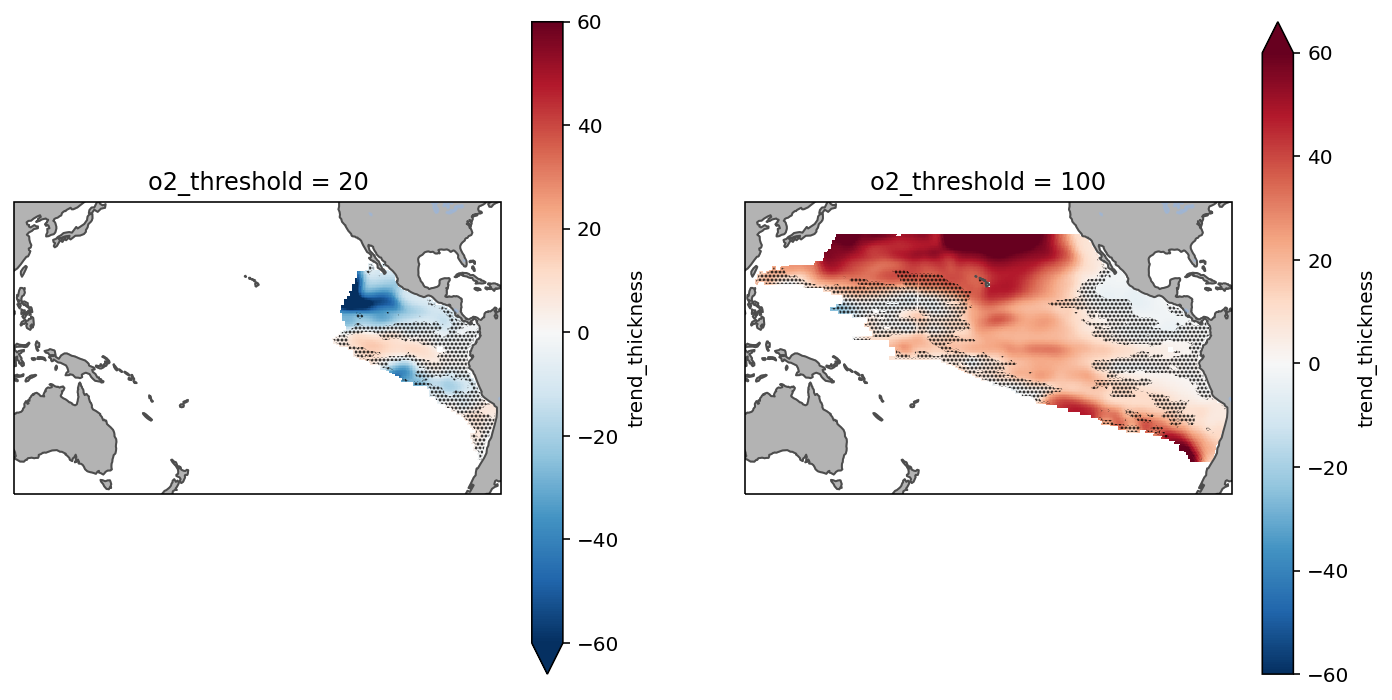

In [48]:
from xarrayutils.utils import sign_agreement
ds = ds_combined_pacific
for var, vmax in [('trend_oxycline', 60), ('trend_thickness', 60)]:
    da = ds[var]
    
    # mask out the areas that do not have many models with an OMZ there.
    nan_mask = mask_multi_model(da)
    # this is pretty arbitrary, in this version it counts areas where we have more than 8 models

    m = da.median('model').where(nan_mask)
    # does this look better? Yes it does!
    m = filter_2D(m, 3, ["y", 'x'])
    s = sign_agreement(da, m, 'model', count_nans=False, threshold=0.65).where(nan_mask)

    # with these parameters there have to be at least 5 models with the same sign to not be stipled!


    o2_th = [20, 100]
    fig, axarr = plt.subplots(
        ncols=len(o2_th),
        nrows=1,
        subplot_kw={'projection':ccrs.Robinson(210)},
        figsize=[12,6],
    )

    for o2, ax in zip(o2_th, axarr):
        map_kwargs = dict(x='lon', y='lat', transform=ccrs.PlateCarree())
        m.sel(o2_threshold=o2).plot(ax=ax, vmax=vmax, **map_kwargs)
        s.sel(o2_threshold=o2).plot.contourf(
            ax=ax,
            levels=[0,0.5],
            hatches=['......', None],
            colors='none',
            add_labels=False, 
            add_colorbar=False,
            **map_kwargs)
        map_util_plot(ax)
        ax.set_extent((120, 290, -45, 45), crs=ccrs.PlateCarree())

Check the multi-model 'sign agreement' between boundary and thickness. This needs to become a SI plot.

Its pretty nice to see that this actually agrees in each one of the models

No `dtype` chosen. Input is Dataset.         Defaults to float64


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


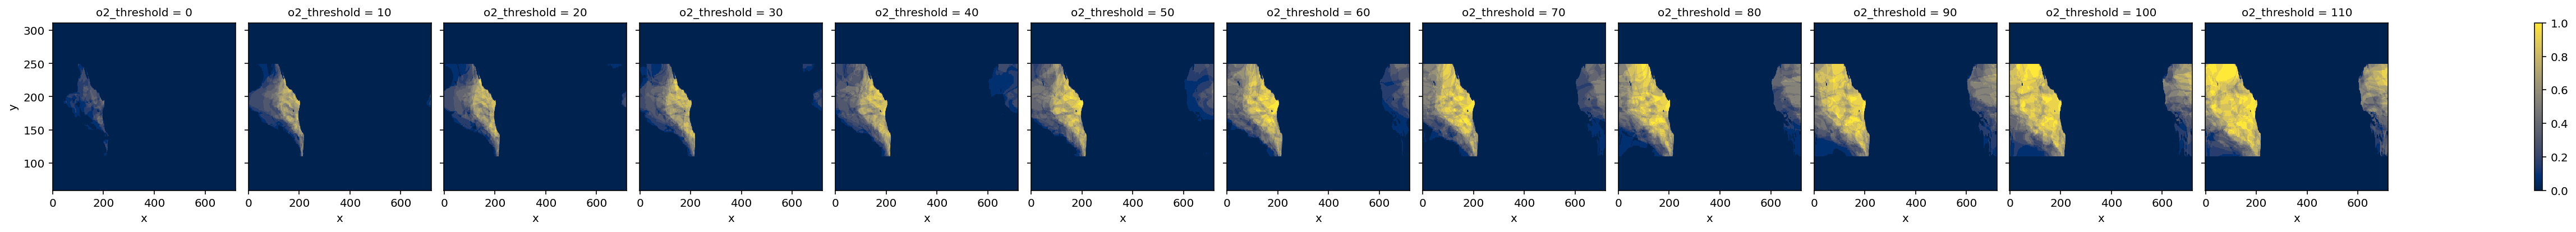

In [26]:
# smooth each model field
ds = filter_2D(ds_combined_pacific, 4, ["y", 'x'])

da = np.sign(-ds.trend_oxycline) == np.sign(ds.trend_thickness)
da.plot(col='model', row='o2_threshold')
da = (da.sum('model')/len(da.model)).plot(col='o2_threshold')

## Relationship between volume change and OMZ boundary

- I might want to filter the point: 
   - exclude points that bottom/top out (delta boundary larger than the depth?)
   - similar thing but for the bottom? Calculate the bottom/top clearance and restrict to values that have some clearance to begin with?

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/p

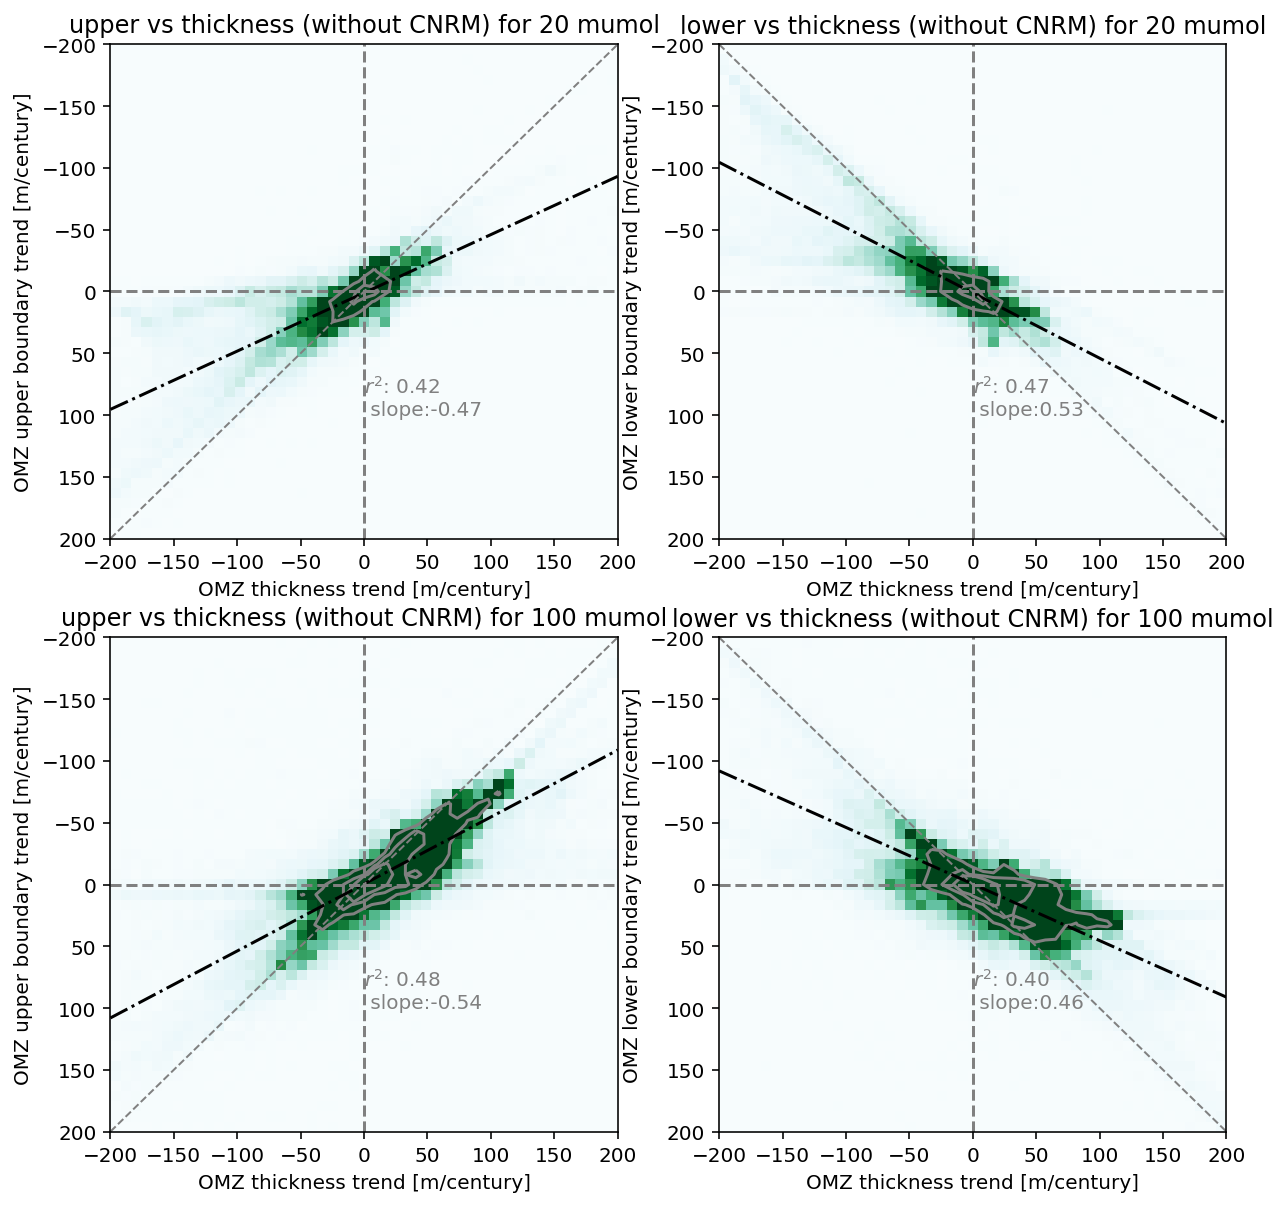

In [49]:
co = 'k'
slope_dict = {}

ds_scatter = ds_combined_pacific.drop_sel(model='CNRM-ESM2-1')
# ds_scatter = ds_combined_pacific.sel(model='CanESM5-CanOE')
# ds_scatter = ds_combined_pacific

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[10, 10])
for th, axarr_sub in [(20, axarr[0,:]), (100, axarr[1,:])]:
    for boundary, ax in zip(['upper', 'lower'], axarr_sub.flat):
        if boundary == 'lower':
            y_var = 'trend_lower_oxycline'
            diagonal_sign = 1
        else:
            y_var = 'trend_oxycline'
            diagonal_sign = -1
        outer_bin = 200
        x_bins = np.linspace(-outer_bin, outer_bin, 50)
        y_bins = np.linspace(-outer_bin, outer_bin, 50)
        x = ds_scatter.sel(o2_threshold=th).trend_thickness
        y = ds_scatter.sel(o2_threshold=th)[y_var]

        hist = histogram(x, y, bins=[x_bins, y_bins])
        hist.plot(
            ax=ax,
            vmin=0,
            vmax=700,
            add_colorbar=False,
            x='trend_thickness_bin',
            cmap='BuGn'
        )
        hist.plot.contour(
            ax=ax,
            colors='0.5',
            x='trend_thickness_bin',
            levels=[1000, 2500, 5000]
        )
        # new weighted regression

        w = (~np.isnan(x)).sum(['x', 'y'])
        # scale weights
        epsilon = 1e-5 # small value to avoid division by zero
        w = (w - w.min()+epsilon) / w.max()
        w = 1/w

        # broadcast weights
        w = (x*0) + w

        # flattern the arrays
        w_flat = w.load().data.reshape(-1, 1)
        x_flat = x.load().data.reshape(-1, 1)
        y_flat = y.load().data.reshape(-1, 1)
        # remove the nans
        nan_mask = np.isnan(x_flat).reshape(-1, 1)
        x_flat = x_flat[~nan_mask]
        y_flat = y_flat[~nan_mask]
        w_flat = w_flat[~nan_mask]

        # remove values that show very large thickness increase to prevent outliers?
        large_value_mask = abs(x_flat) < outer_bin
        x_flat = x_flat[large_value_mask]
        y_flat = y_flat[large_value_mask]
        w_flat = w_flat[large_value_mask]

    #     clf = linear_model.LinearRegression()
    #     clf.fit(x_flat.reshape(-1, 1), y_flat.reshape(-1, 1), sample_weight=w_flat)
    #     m = np.squeeze(clf.coef_)
    #     b = np.squeeze(clf.intercept_)
    #     line = x_bins * m + b
    #     ax.text(0, -100, f" all models (weighted): \n $r^2$: {100:.2f} \n slope:{m:.2f}", color='0.5')
    #     ax.plot(x_bins, line, color='c')

        # Old regression over everything. This is likely biased towards the models with large OMZ
    #     x_flat = xr.DataArray(x.data.flatten(), dims=['x'])
    #     y_flat = xr.DataArray(y.data.flatten(), dims=['x'])
        reg = xr_linregress(
            xr.DataArray(x_flat, dims=['dummy']),
            xr.DataArray(y_flat, dims=['dummy']),
            'dummy'
        ).load()
        # parse slope into dict for later
    #     slope_dict[m][th][boundary] = reg.slope.data
        line = x_bins * reg.slope.data + reg.intercept.data
        ax.text(0, 100, f"$r^2$: {reg.r_value.data**2:.2f} \n slope:{reg.slope.data:.2f}", color='0.5')
        ax.plot(x_bins, line, color='k', ls='-.')


        outer_bin_plot = outer_bin
        ax.set_xlim(-outer_bin_plot, outer_bin_plot)
        ax.set_ylim(outer_bin_plot, -outer_bin_plot)
        ax.axhline(0, color='0.5', ls='--')
        ax.axvline(0, color='0.5', ls='--')
        # plot expected line
        ax.plot(x_bins, diagonal_sign * x_bins, ls='--', lw=1, color='0.5')
        ax.set_xlabel('OMZ thickness trend [m/century]')
        ax.set_ylabel(f'OMZ {boundary} boundary trend [m/century]')
        ax.set_title(f'{boundary} vs thickness (without CNRM) for {th} mumol')

## Correlate oxycline with thickness for each model

KeyError: 120

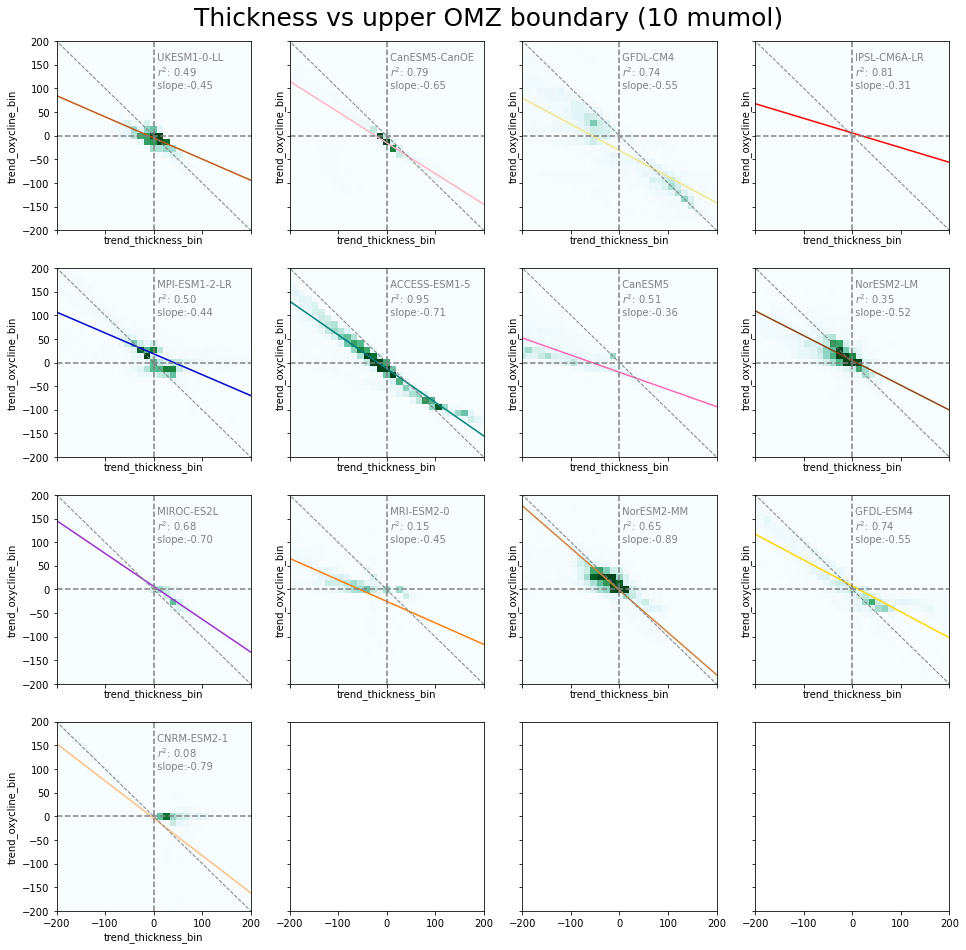

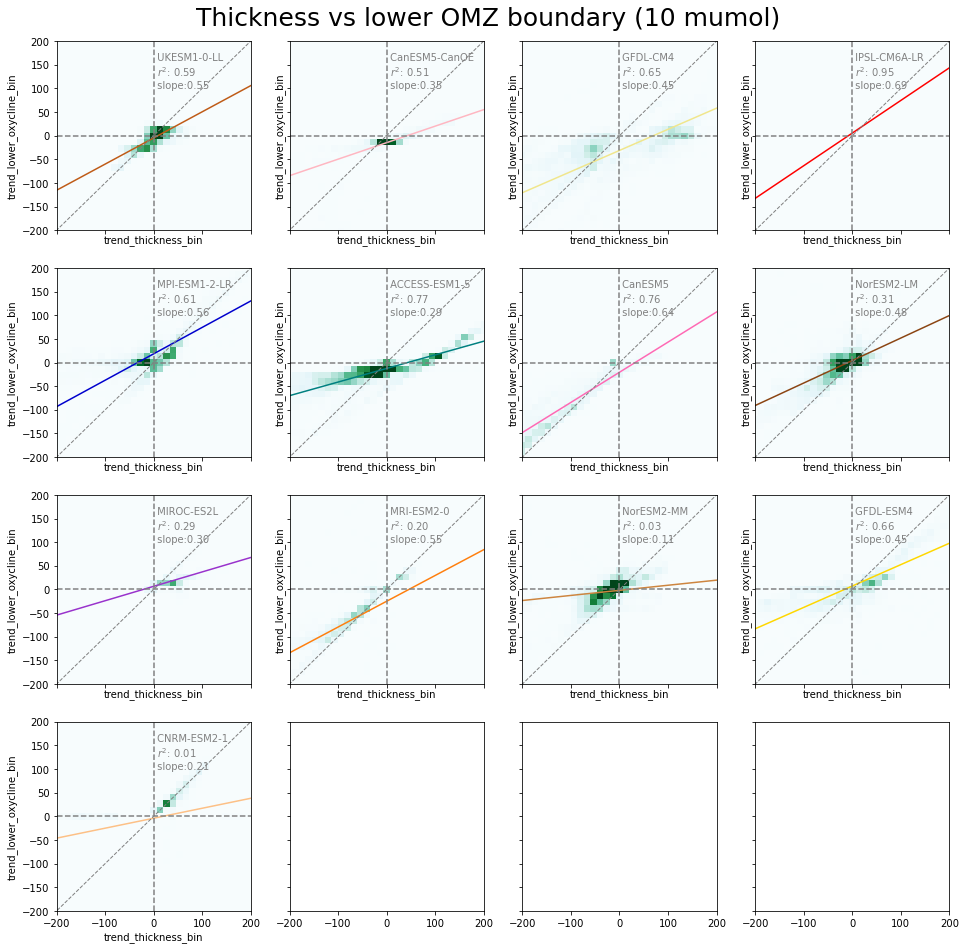

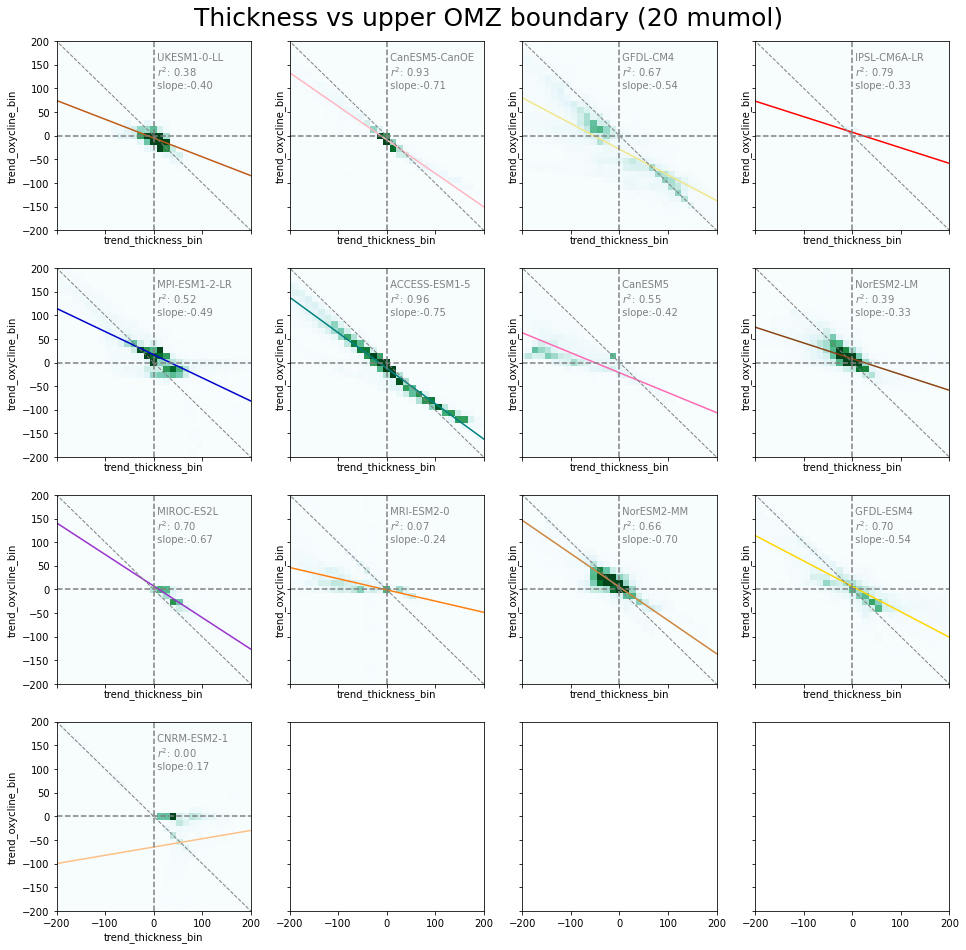

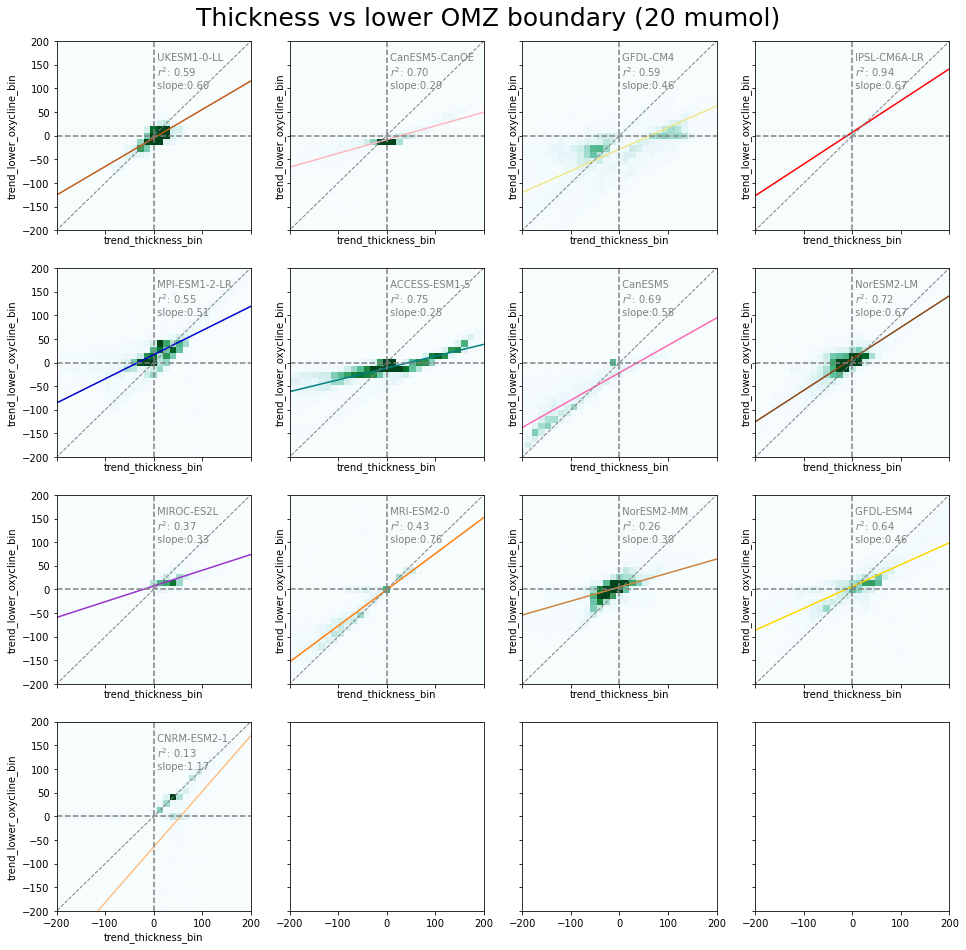

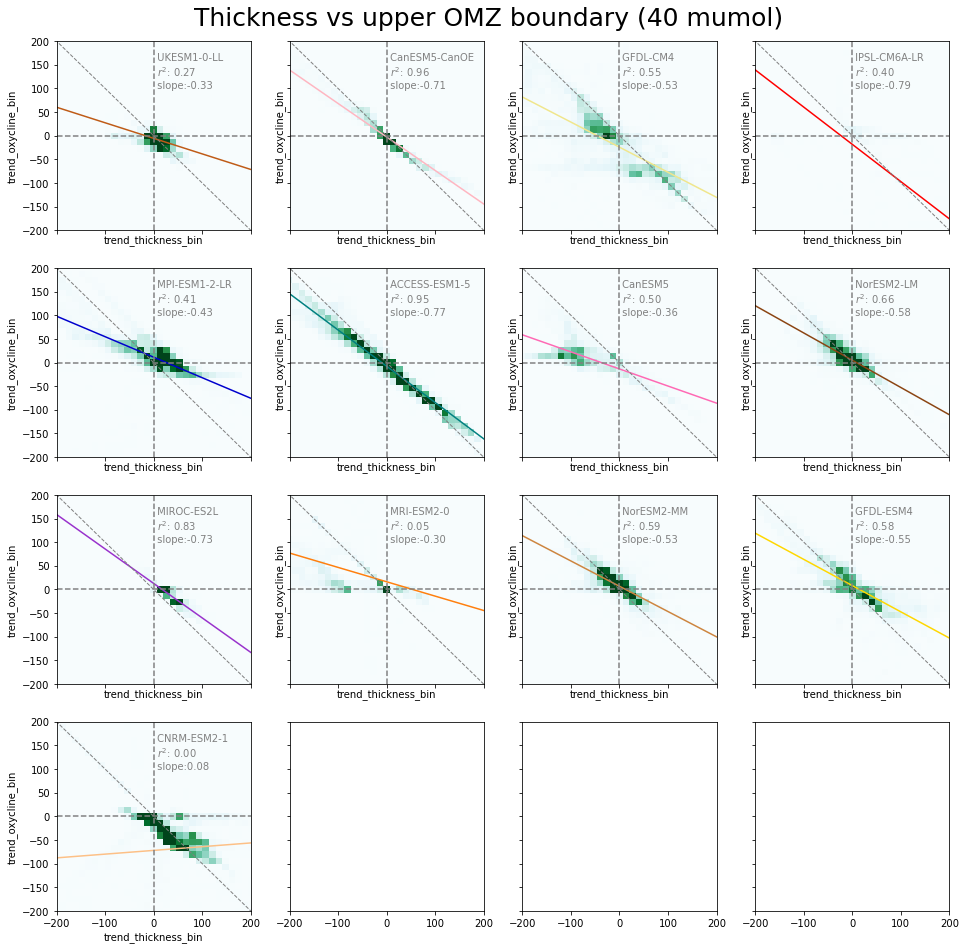

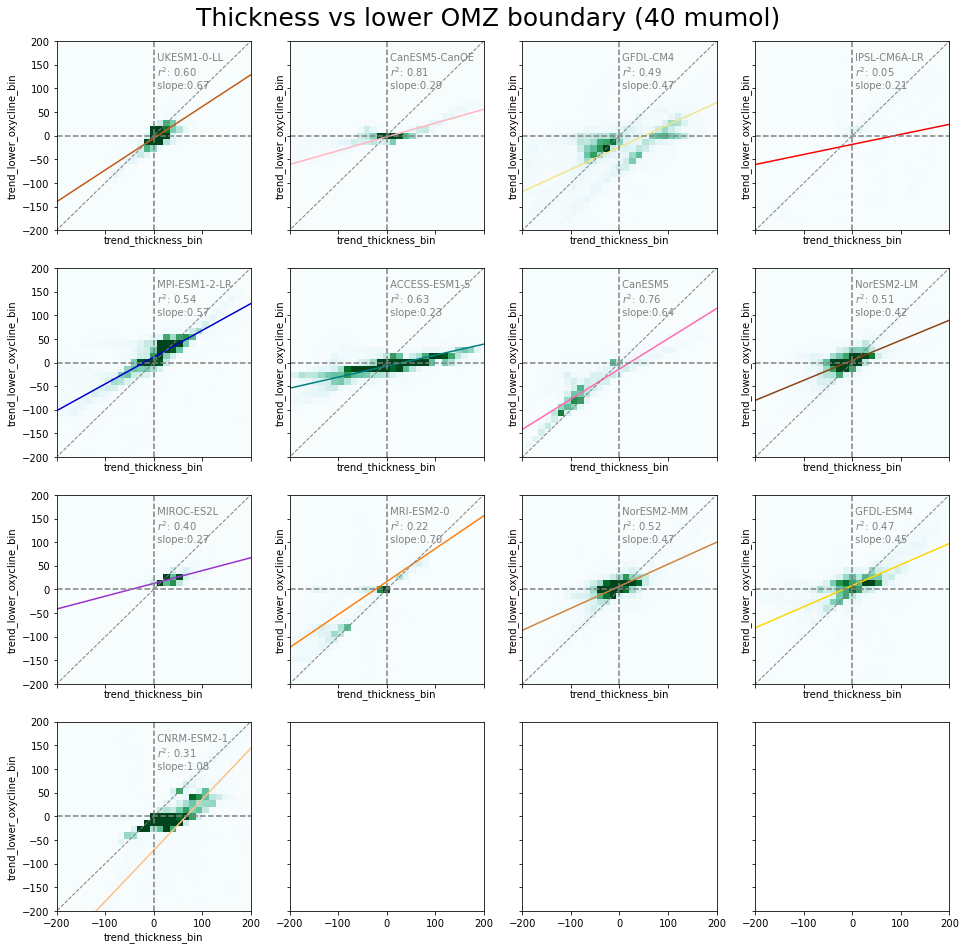

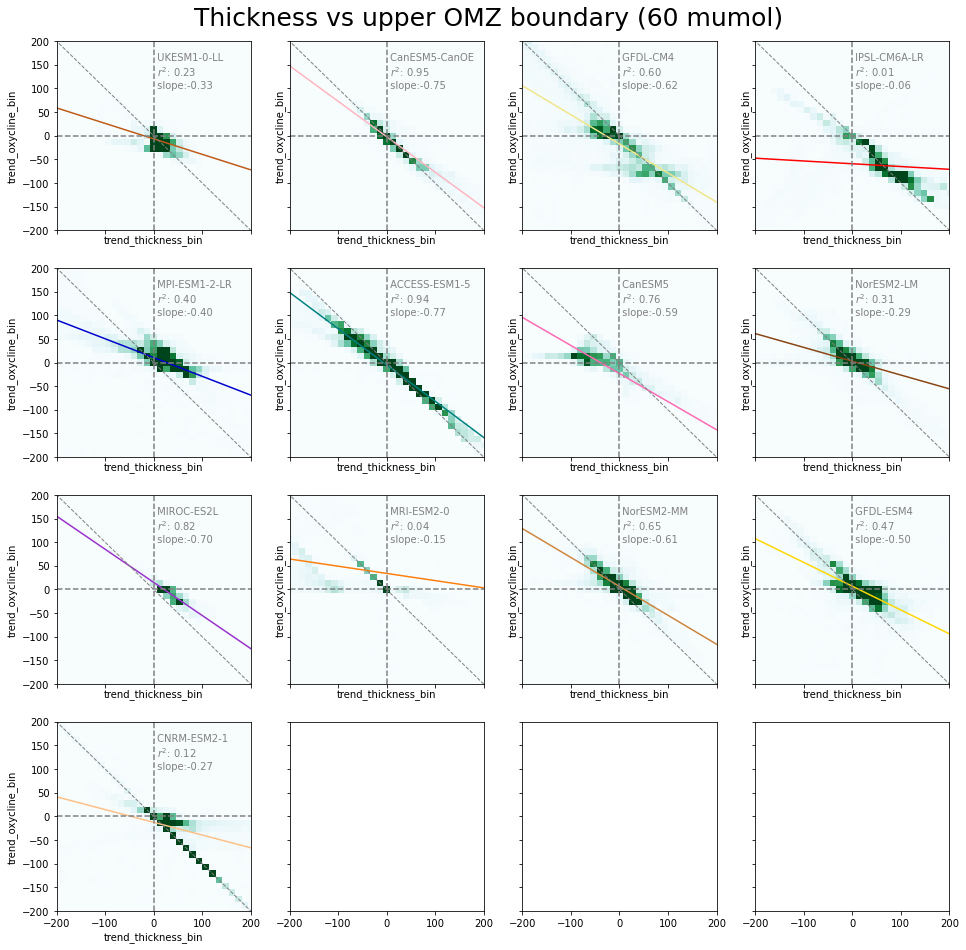

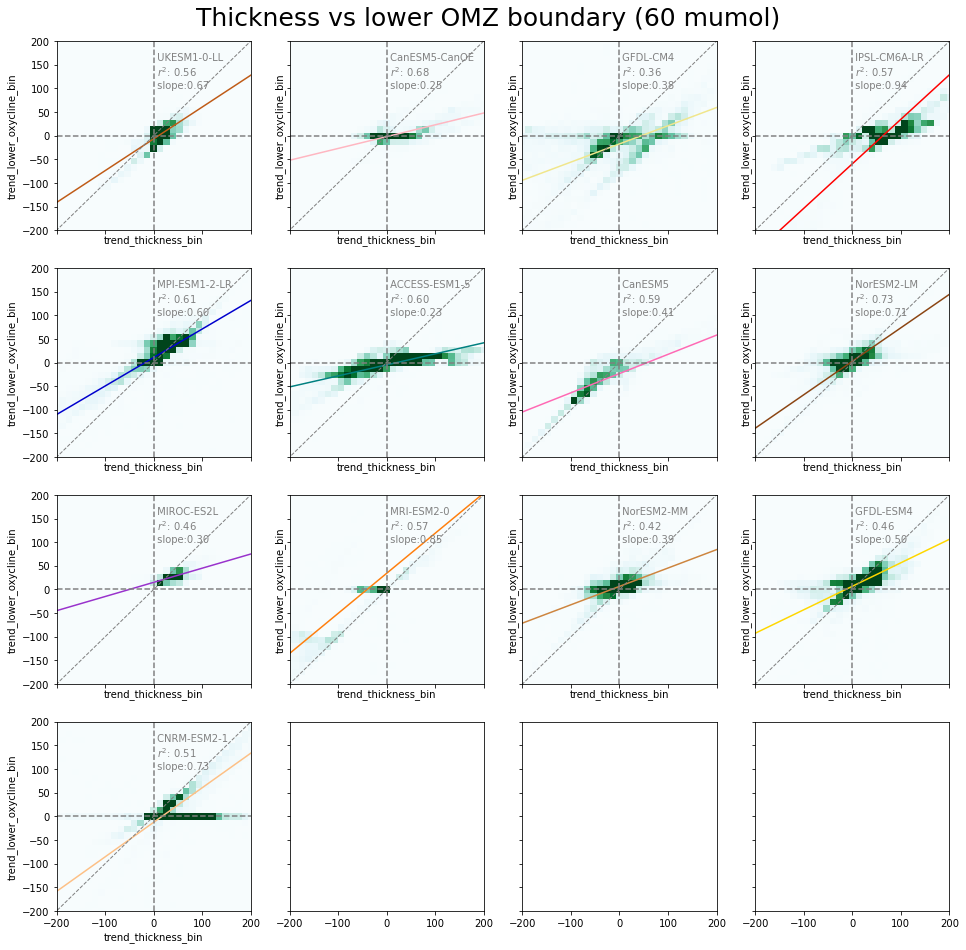

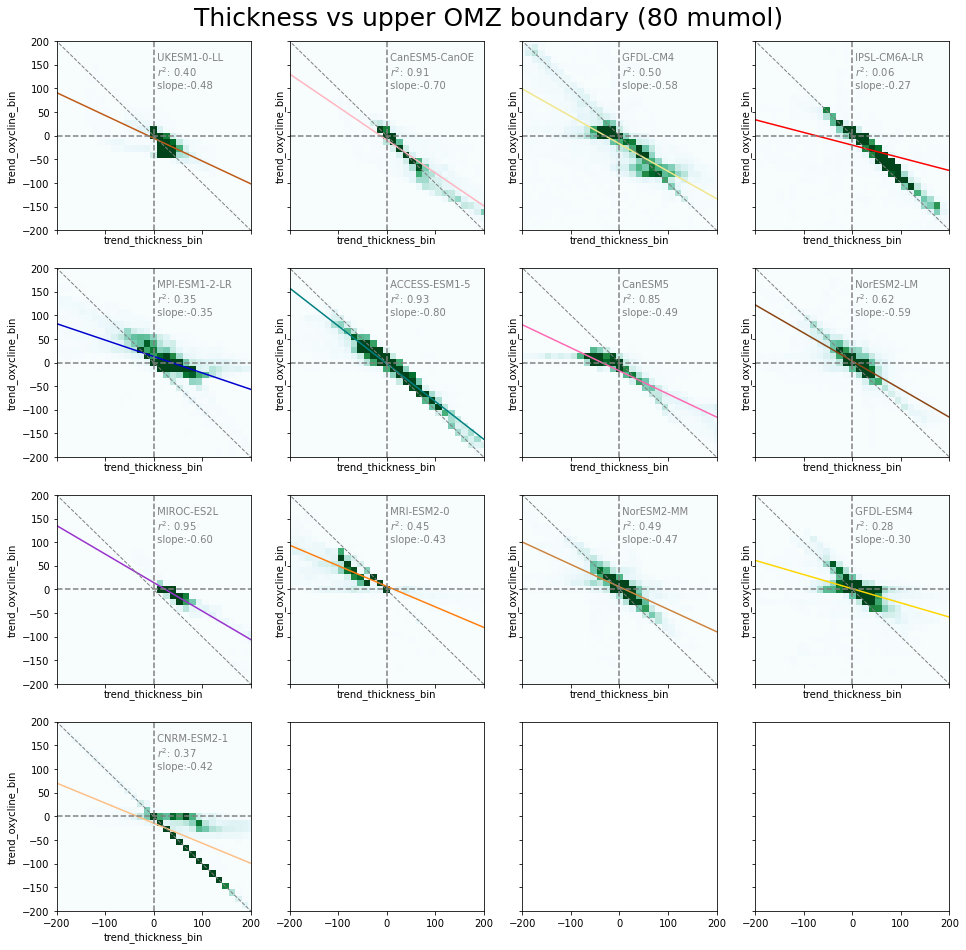

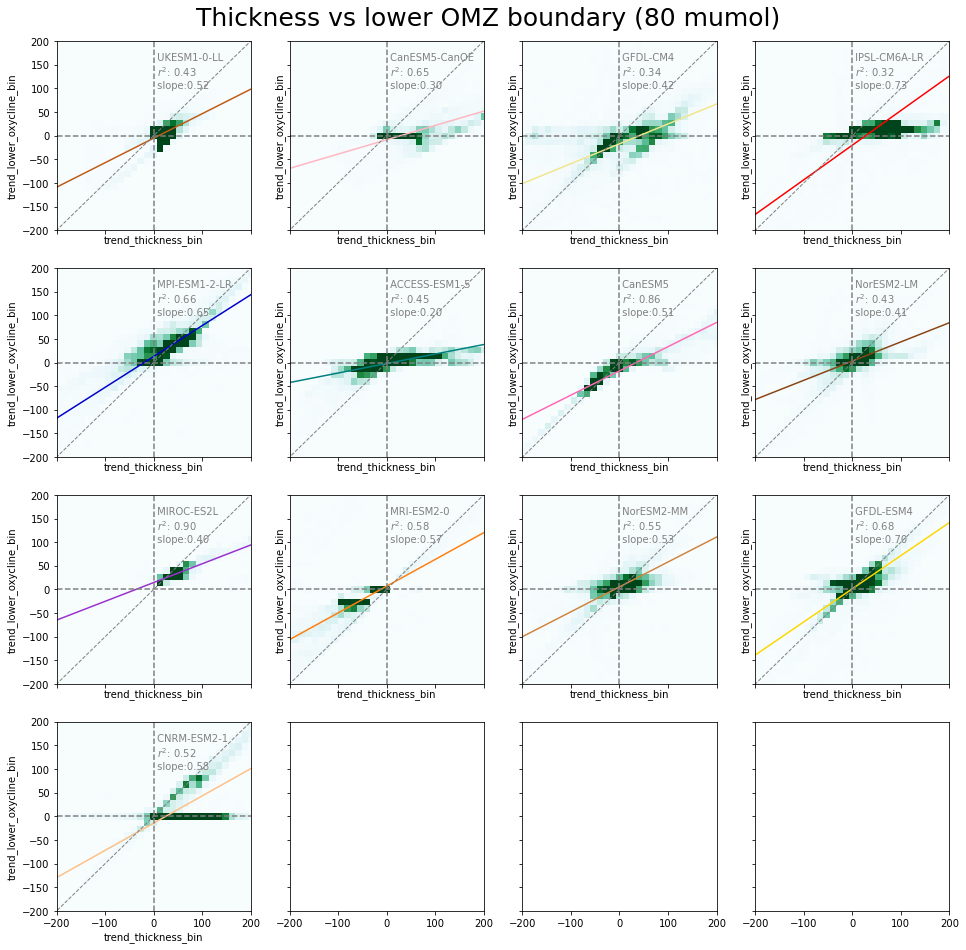

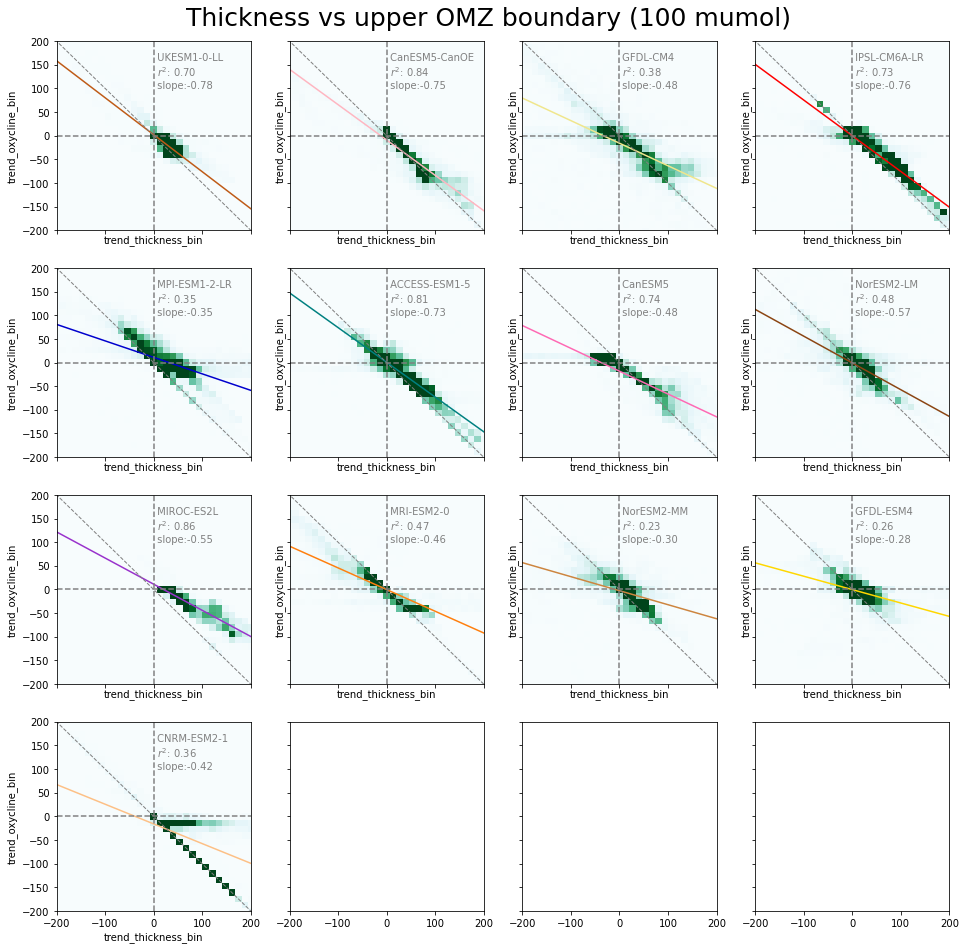

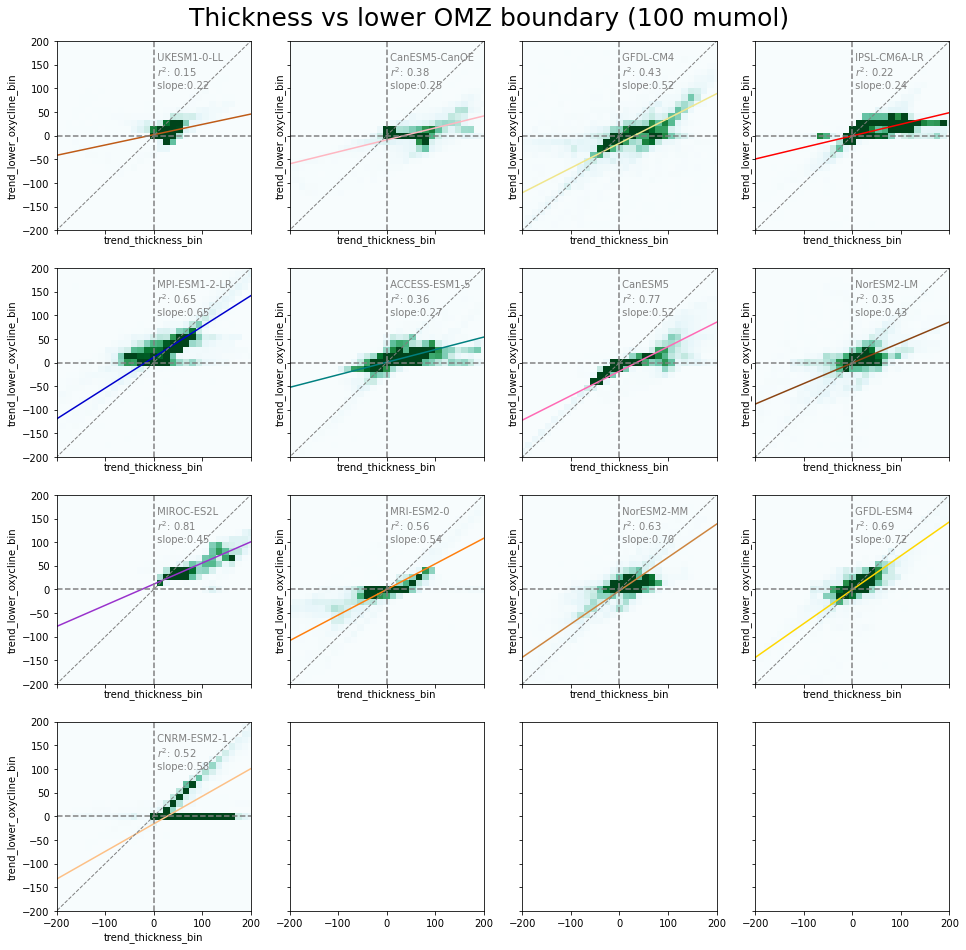

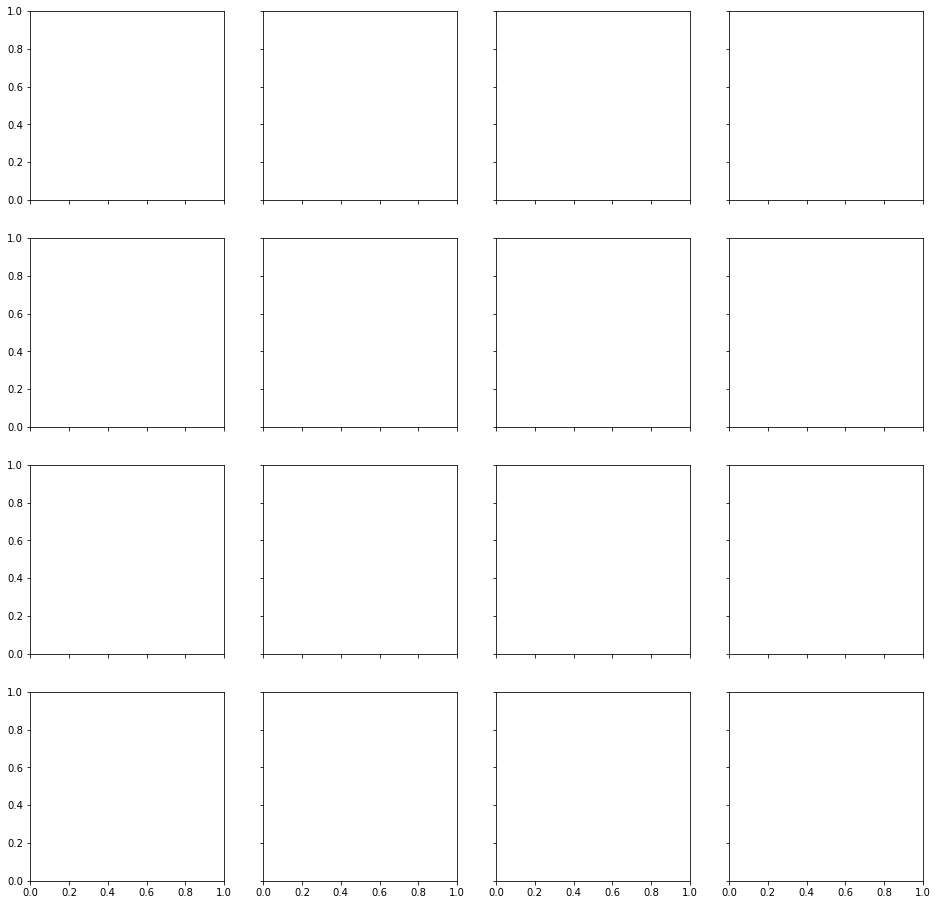

In [102]:
models = ds_combined_pacific.model.data
thresholds = [10, 20, 40, 60, 80, 100, 120]

slope_dict = {m:{th:{'upper':np.nan, 'lower':np.nan} for th in thresholds} for m in models}
for th in thresholds:
    for boundary in ['upper', 'lower']:
        if boundary == 'lower':
            y_var = 'trend_lower_oxycline'
            diagonal_sign = 1
        else:
            y_var = 'trend_oxycline'
            diagonal_sign = -1


        fig, axarr = plt.subplots(ncols=4, nrows=4, figsize=[4*4, 4*4], sharex=True, sharey=True)
        for m, ax in zip(models, axarr.flat):
            co = o2_model_colors()[m]

            x_bins = np.linspace(-1000, 1000, 150)
            y_bins = np.linspace(-1000, 1000, 150)
            x = ds_combined_pacific.sel(model=m, o2_threshold=th).trend_thickness
            y = ds_combined_pacific.sel(model=m, o2_threshold=th)[y_var]
            hist = histogram(x, y, bins=[x_bins, y_bins])
        #     hist.plot.contour(colors=[co],levels=[1, 100, 1000, 5000, 10000])
            hist.plot(ax=ax, vmin=0, vmax=5e2, add_colorbar=False, x='trend_thickness_bin', cmap='BuGn')
            #norm=matplotlib.colors.LogNorm(),
            x_flat = xr.DataArray(x.data.flatten(), dims=['x'])
            y_flat = xr.DataArray(y.data.flatten(), dims=['x'])
            reg = xr_linregress(x_flat, y_flat, 'x').load()
            # parse slope into dict for later
            slope_dict[m][th][boundary] = reg.slope.data
            line = x_bins * reg.slope.data + reg.intercept.data
            ax.plot(x_bins, line, color=co)
            ax.text(0, 100, f" {m} \n $r^2$: {reg.r_value.data**2:.2f} \n slope:{reg.slope.data:.2f}", color='0.5')
            ax.set_xlim(-200, 200)
            ax.set_ylim(-200, 200)
            ax.axhline(0, color='0.5', ls='--')
            ax.axvline(0, color='0.5', ls='--')
            # plot expected line
            ax.plot(x_bins, diagonal_sign * x_bins, ls='--', lw=1, color='0.5')
        fig.suptitle(f"Thickness vs {boundary} OMZ boundary ({th} mumol)", y=0.91, fontsize=25)

## quantify if each model responds more top or bottom to changes in thickness (volume)

In [ ]:
slope_dict

# th = 100
plt.figure()
for th in thresholds:
    for mi, m in enumerate(np.sort(models)):
        upper = slope_dict[m][th]['upper']
        lower = slope_dict[m][th]['lower']
        plt.scatter(mi, -upper/lower, c=o2_model_colors()[m], s=th, alpha=0.75)
        assert np.isclose(-upper+lower, 1.0)
model_color_legend()
plt.axhline(1, color='0.5', ls='--')
plt.ylabel('Ratio upper/lower regression slope')

Text(0.5, 0.91, 'Thickness vs Lower OMZ boundary (100 mumol)')

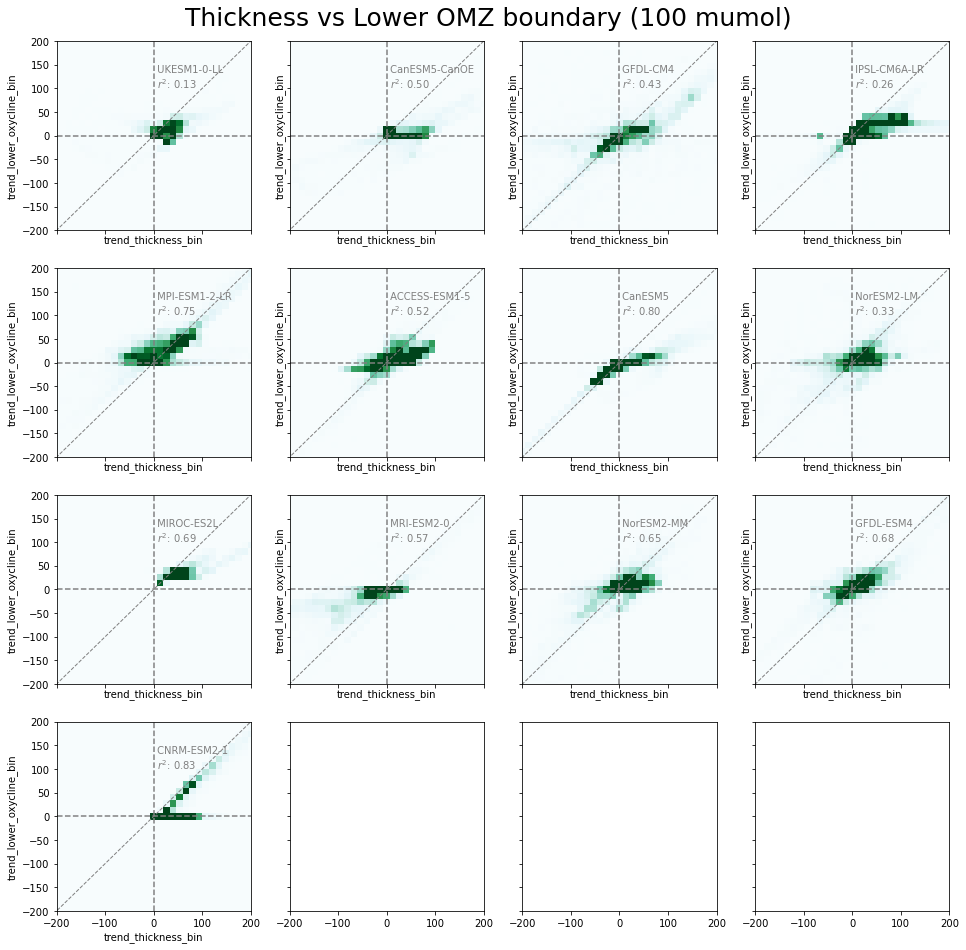

In [44]:
th = 100


fig, axarr = plt.subplots(ncols=4, nrows=4, figsize=[4*4, 4*4], sharex=True, sharey=True)
for m, ax in zip(ds_combined_pacific.model.data, axarr.flat):
    co = o2_model_colors()[m]
        
    x_bins = np.linspace(-1000, 1000, 150)
    y_bins = np.linspace(-1000, 1000, 150)
    x = ds_combined_pacific.sel(model=m, o2_threshold=th).trend_thickness
    y = ds_combined_pacific.sel(model=m, o2_threshold=th).trend_lower_oxycline
    hist = histogram(x, y, bins=[x_bins, y_bins])
#     hist.plot.contour(colors=[co],levels=[1, 100, 1000, 5000, 10000])
    hist.plot(ax=ax, vmin=0, vmax=5e2, add_colorbar=False, x='trend_thickness_bin', cmap='BuGn')
    #norm=matplotlib.colors.LogNorm(),
    x_flat = xr.DataArray(x.data.flatten(), dims=['x'])
    y_flat = xr.DataArray(y.data.flatten(), dims=['x'])
    reg = xr_linregress(x_flat, y_flat, 'x').load()
    line = x_bins * reg.slope.data + reg.intercept.data
#     ax.plot(x_bins, line, color=co)
    ax.text(0, 100, f" {m} \n $r^2$: {reg.r_value.data**2:.2f}", color='0.5')
    ax.set_xlim(-200, 200)
    ax.set_ylim(-200, 200)
    ax.axhline(0, color='0.5', ls='--')
    ax.axvline(0, color='0.5', ls='--')
    # plot expected line
    ax.plot(x_bins, x_bins, ls='--', lw=1, color='0.5')
fig.suptitle(f"Thickness vs Lower OMZ boundary ({th} mumol)", y=0.91, fontsize=25)

## Trend Maps (for SI)

UKESM1-0-LL
No `dtype` chosen. Input is Dataset.         Defaults to float64
CanESM5-CanOE
No `dtype` chosen. Input is Dataset.         Defaults to float64
GFDL-CM4
No `dtype` chosen. Input is Dataset.         Defaults to float64
MPI-ESM1-2-HR
No `dtype` chosen. Input is Dataset.         Defaults to float64
IPSL-CM6A-LR
No `dtype` chosen. Input is Dataset.         Defaults to float64
MPI-ESM1-2-LR
No `dtype` chosen. Input is Dataset.         Defaults to float64
ACCESS-ESM1-5
No `dtype` chosen. Input is Dataset.         Defaults to float64
CanESM5
No `dtype` chosen. Input is Dataset.         Defaults to float64
NorESM2-LM
No `dtype` chosen. Input is Dataset.         Defaults to float64
MIROC-ES2L
No `dtype` chosen. Input is Dataset.         Defaults to float64
MRI-ESM2-0
No `dtype` chosen. Input is Dataset.         Defaults to float64
NorESM2-MM
No `dtype` chosen. Input is Dataset.         Defaults to float64
GFDL-ESM4
No `dtype` chosen. Input is Dataset.         Defaults to float64
CNR

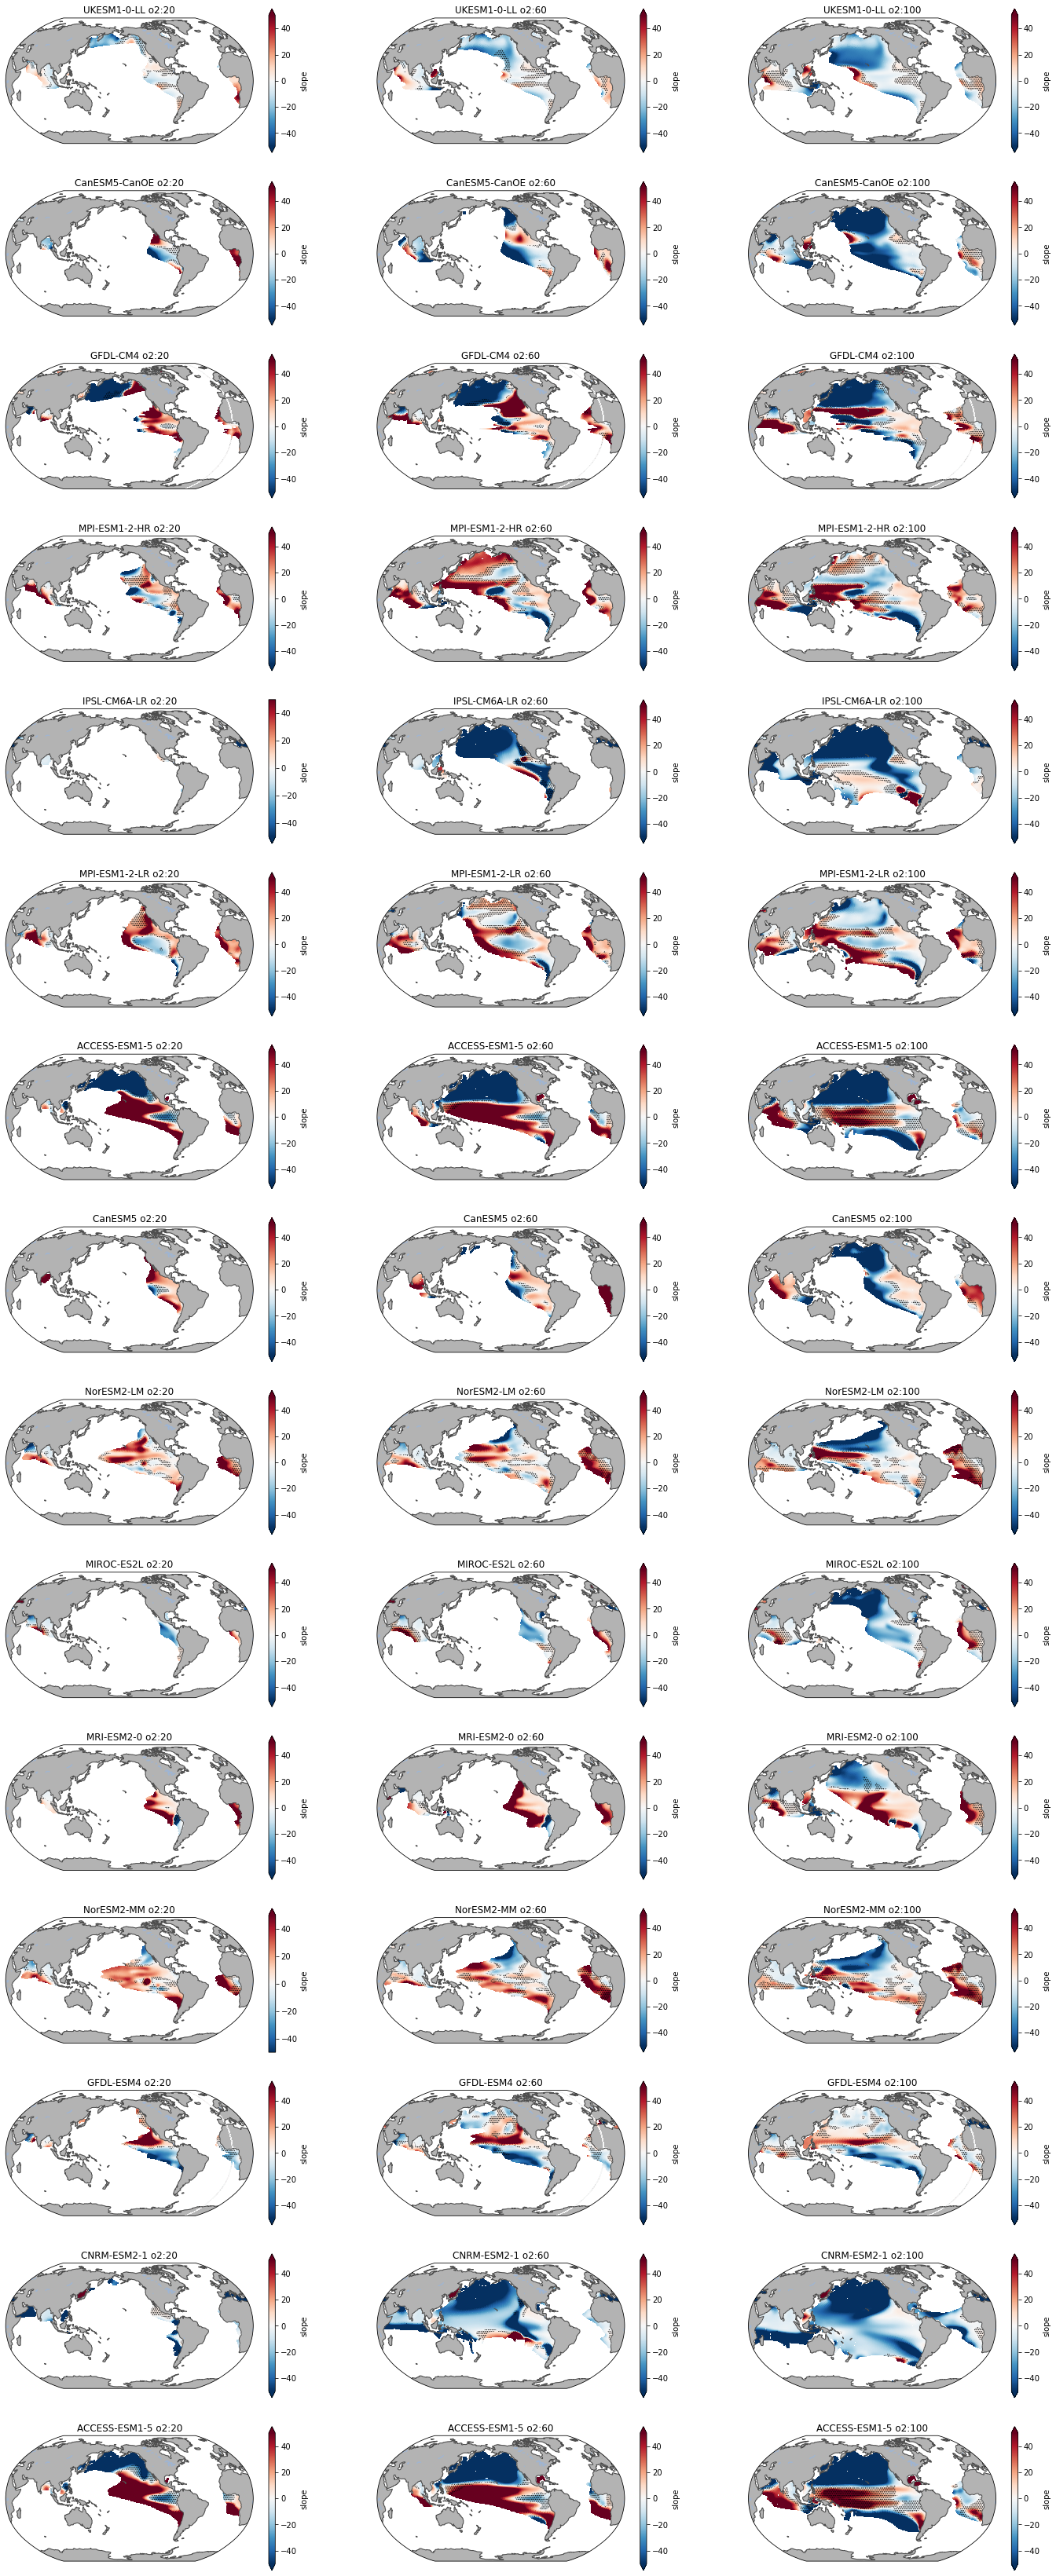

In [31]:
ddict_plot = {k: v for k, v in ddict.items()}
thresholds = [20, 60, 100]
nx = len(thresholds)
ny = len(ddict_plot)
fig, axarr = plt.subplots(
    ncols=nx,
    nrows=ny,
    figsize=[nx * 8, ny * 4],
    subplot_kw={"projection": ccrs.Robinson(210)},
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for ti, th in enumerate(thresholds):
        for ni, (name, ds) in enumerate(ddict_plot.items()):
            ax = axarr[ni, ti]
            ds = preprocess(ds, th)
            ds = ds.sel(o2_threshold=th)
            model = ds.source_id
            print(model)

            # regrid onto a regular grid
            ds = regrid(ds)

            # smooth the data
            ds_smooth = filter_2D(ds, 2, ["x", "y"])

            # add thickness
            ds_smooth["thickness"] = ds_smooth.lower_boundary - ds_smooth.upper_boundary

            # compute trends
            trend_thickness = linear_trend(ds_smooth["thickness"], "time").slope * 100
            trend_oxycline = (
                linear_trend(ds_smooth["upper_boundary"], "time").slope * 100
            )

            trend_thickness = trend_thickness.load()
            trend_oxycline = trend_oxycline.load()

            plot_kwargs = dict(x="lon", y="lat", transform=ccrs.PlateCarree())
            trend_oxycline.plot(ax=ax, vmax=50, **plot_kwargs)
            # plot the sign agreement with
            # increase in thickness should lead to shallowing (decreasing).
            sa = np.sign(trend_oxycline) == np.sign(-trend_thickness)
            # reintroduce the nans
            sa = sa.where(~np.isnan(trend_oxycline))
            sa.plot.contourf(
                ax=ax,
                alpha=0,
                hatches=[".....", None],
                levels=[0, 0.5],
                add_labels=False,
                add_colorbar=False,
                ** plot_kwargs,
            )

            ax.set_title(f"{model} o2:{th}")
            map_util_plot(ax)
            ax.set_global()
plt.show()